Define Emotion Map and Feature Extraction

In [1]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    return np.mean(mfccs.T, axis=0)


Load Data Function

In [2]:
def load_data(dataset_path):
    x, y = [], []

    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(folder_path, file)
                emotion_code = file.split("-")[2]
                emotion_label = emotion_map.get(emotion_code)

                if emotion_label:
                    features = extract_features(file_path)
                    x.append(features)
                    y.append(emotion_label)

    encoder = LabelEncoder()
    y_encoded = to_categorical(encoder.fit_transform(y))

    return train_test_split(np.array(x), y_encoded, test_size=0.2, random_state=42), encoder


 Load Dataset

In [3]:
dataset_path = r"C:\Users\gourab\Downloads\Training audio"
(x_train, x_test, y_train, y_test), encoder = load_data(dataset_path)


Define Model

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

def build_model(input_shape, num_classes):
    model = Sequential()
    model.add(Dense(256, input_shape=(input_shape,), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


Train the Model

In [5]:
model = build_model(x_train.shape[1], y_train.shape[1])

history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(x_test, y_test)
)


Epoch 1/50


c:\Users\gourab\Desktop\Speech_emotion_recogniser\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.1724 - loss: 2.5061 - val_accuracy: 0.1528 - val_loss: 11.6395
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2480 - loss: 2.0420 - val_accuracy: 0.1285 - val_loss: 5.6001
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2596 - loss: 1.9916 - val_accuracy: 0.1944 - val_loss: 3.6780
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3320 - loss: 1.8568 - val_accuracy: 0.3021 - val_loss: 2.0300
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2954 - loss: 1.8844 - val_accuracy: 0.3646 - val_loss: 1.7675
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3079 - loss: 1.8191 - val_accuracy: 0.3125 - val_loss: 1.6895
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3331 - loss: 1.7838 - val_accuracy: 0.3715 - val_loss: 1.6469
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3672 - loss: 1.6679 - val_accuracy: 0.3507 - val_loss: 1.7656
E

Predict Emotion from Audio File

In [6]:
def predict_emotion(file_path):
    feature = extract_features(file_path)
    feature = feature.reshape(1, -1)
    prediction = model.predict(feature)
    predicted_label = encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]

# Example:
test_file = r"C:\Users\gourab\Downloads\Training audio\Actor_01\03-01-05-01-01-01-01.wav"
print("Predicted Emotion:", predict_emotion(test_file))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Predicted Emotion: angry


save model

In [7]:
model.save("audio_sentiment_model.h5")

import pickle
with open("encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)


Performance Graph

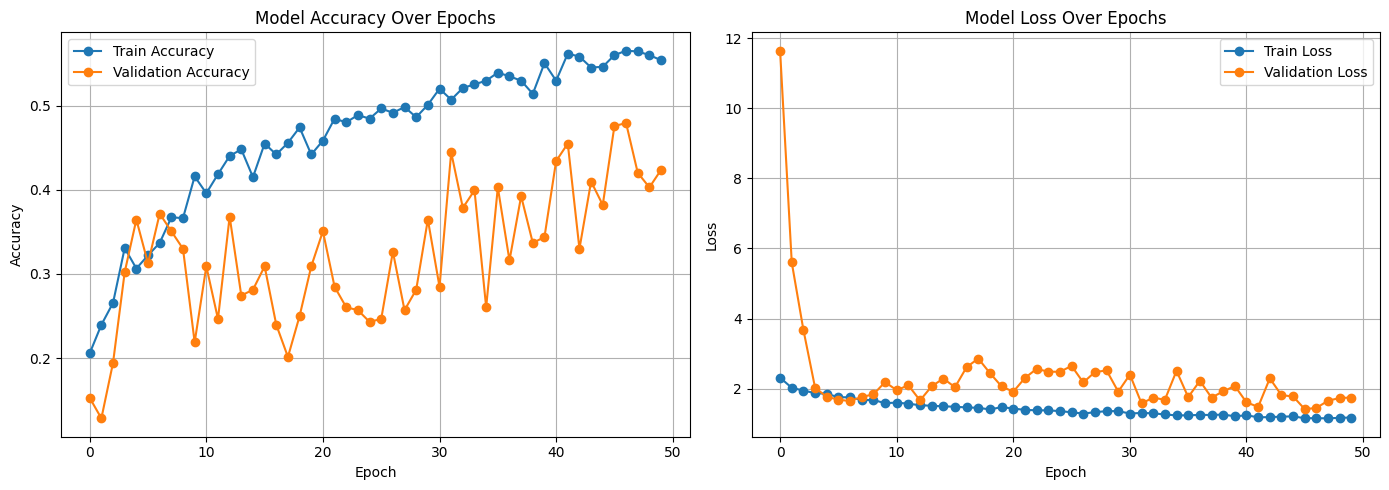

In [8]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
